In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 32.1 MB/s 
     |████████████████████████████████| 182 kB 71.1 MB/s 
     |████████████████████████████████| 7.6 MB 4.3 MB/s 


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [3]:
df = pd.read_csv("/content/train_skills.csv")
df.head()

,phrase,skill
0,with cloud,0.0
1,work,0.0
2,digital products,0.0
3,computer science/engineering,1.0
4,universities,0.0


In [4]:
df.dropna(inplace=True)
index=df[df['skill']==10].index
print(index)
df.drop(index,inplace=True)

Int64Index([2278], dtype='int64')


In [5]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['phrase'], df['skill'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=df['skill'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [6]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


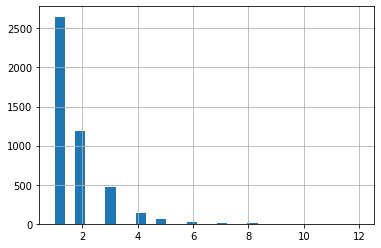

In [8]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [9]:
max_seq_len=4

In [10]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [11]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [13]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [14]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask,return_dict=False)
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [15]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [16]:
from torch.optim import Adamax
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = Adamax(model.parameters(), lr = 0.01)

In [17]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
#class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights
print(class_weights)

[1.07022076 0.93842669]


In [18]:
# convert class weights to tensor
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

# number of training epochs
epochs = 10

In [19]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels.type(torch.LongTensor).to(device))

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [20]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels.type(torch.LongTensor).to(device))

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [21]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights3.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    143.
  Batch   100  of    143.

Evaluating...

Training Loss: 1.342
Validation Loss: 0.603

 Epoch 2 / 10
  Batch    50  of    143.
  Batch   100  of    143.

Evaluating...

Training Loss: 0.616
Validation Loss: 0.533

 Epoch 3 / 10
  Batch    50  of    143.
  Batch   100  of    143.

Evaluating...

Training Loss: 0.589
Validation Loss: 0.517

 Epoch 4 / 10
  Batch    50  of    143.
  Batch   100  of    143.

Evaluating...

Training Loss: 0.565
Validation Loss: 0.478

 Epoch 5 / 10
  Batch    50  of    143.
  Batch   100  of    143.

Evaluating...

Training Loss: 0.575
Validation Loss: 0.652

 Epoch 6 / 10
  Batch    50  of    143.
  Batch   100  of    143.

Evaluating...

Training Loss: 0.573
Validation Loss: 0.520

 Epoch 7 / 10
  Batch    50  of    143.
  Batch   100  of    143.

Evaluating...

Training Loss: 0.555
Validation Loss: 0.465

 Epoch 8 / 10
  Batch    50  of    143.
  Batch   100  of    143.

Evaluating...

Training Loss: 0.535
Validat

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
!cp saved_weights3.pt /content/drive/MyDrive

In [22]:
#load weights of best model
#path = 'saved_weights3.pt'
model.load_state_dict(torch.load('/content/saved_weights3.pt'))

<All keys matched successfully>

In [39]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [40]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

         0.0       0.71      0.82      0.76       267
         1.0       0.81      0.71      0.76       303

    accuracy                           0.76       570
   macro avg       0.76      0.76      0.76       570
weighted avg       0.77      0.76      0.76       570



In [41]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0.0,218,49
1.0,88,215


In [42]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

In [43]:
print("Area under ROC:", roc_auc_score(test_y,preds,multi_class="ovo",average='weighted'))

Area under ROC: 0.7630251789223866


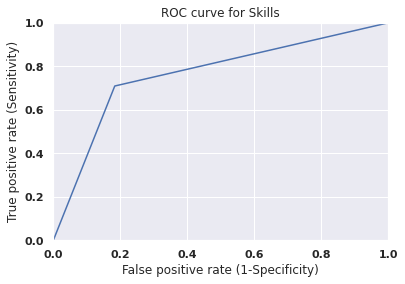

In [44]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(test_y,preds)
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Skills')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

In [45]:
import pandas as pd
import numpy as np 
import re

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
sns.set()
# # used for better images in medium article
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

# Required downloads for use with above models
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [46]:
df1 = pd.read_csv(r'/content/indeed_job_dataset.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5715 entries, 0 to 5714
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        5715 non-null   int64  
 1   Job_Title                         5715 non-null   object 
 2   Link                              5715 non-null   object 
 3   Queried_Salary                    5715 non-null   object 
 4   Job_Type                          5715 non-null   object 
 5   Skill                             5483 non-null   object 
 6   No_of_Skills                      5715 non-null   int64  
 7   Company                           5611 non-null   object 
 8   No_of_Reviews                     4753 non-null   float64
 9   No_of_Stars                       4753 non-null   float64
 10  Date_Since_Posted                 5611 non-null   float64
 11  Description                       5413 non-null   object 
 12  Locati

In [47]:
df_desc=df1.Description
df_desc

0       [<p><b>POSITION SUMMARY</b></p>, <p>\r\r\nThe ...
1       [<p><b>What do we need?</b></p>, <ul><li>\r\r\...
2       [<ul><li>Validate, analyze, and conduct statis...
3       [<p>Full time</p>, <p>Washington, DC metro are...
4       [<ul><li>Assist in consultations with business...
                              ...                        
5710                                                  NaN
5711    [<p>Want to change the world? How about contri...
5712    [<ul><li>Identify and solve hybrid cloud data ...
5713    [<p>At Capital One, we’re building a leading i...
5714    [<ul><li>Develops parallel data-intensive syst...
Name: Description, Length: 5715, dtype: object

In [48]:
def clean_text(raw):
    '''Case specific to be used with pandas apply method'''
    try:
        # remove carriage returns and new lines
        raw = raw.replace('\r', '')
        raw = raw.replace('\n', '')
        
        # brackets appear in all instances
        raw = raw.replace('[', '')
        raw = raw.replace(']', '')
        raw = raw.replace(')', '')
        raw = raw.replace('(', '')
        
        # removing html tags
        clean_html = re.compile('<.*?>')
        clean_text = re.sub(clean_html, ' ', raw)
        
        # removing duplicate whitespace in between words
        clean_text = re.sub(" +", " ", clean_text) 
        
        # stripping first and last white space 
        clean_text = clean_text.strip()
        
        # commas had multiple spaces before and after in each instance
        clean_text = re.sub(" , ", ", ", clean_text) 
        
        # eliminating the extra comma after a period
        clean_text = clean_text.replace('.,', '.')
        
        # using try and except due to Nan in the column
    except:
        clean_text = np.nan
        
    return clean_text

In [49]:
df_desc = df_desc.apply(clean_text)

In [50]:
df_desc = pd.DataFrame(df_desc)
df_desc.dropna(inplace = True)
df_desc.reset_index(inplace = True, drop = True)
#df_desc['lower_description'] = df_desc.Description.str.lower()

In [51]:
def pos_series(keyword):
    '''categorizes after tokenizing words with POS tags'''
    tokens = nltk.word_tokenize(keyword)
    tagged = nltk.pos_tag(tokens)
    return tagged

In [52]:
def grammar(pos_tagged):
  grammar1 = ('''Noun Phrases: {<DT>?<JJ>*<NN|NNS|NNP>+}''')
  chunkParser = nltk.RegexpParser(grammar1)
  tree1 = chunkParser.parse(pos_tagged_arrs)
  grammar2 = ('''NP2: {<IN>?<JJ|NN>*<NNS|NN>}''')
  chunkParser = nltk.RegexpParser(grammar2)
  tree2 = chunkParser.parse(pos_tagged_arrs)
  grammar3 = ('''VS: {<VBG|VBZ|VBP|VBD|VB|VBN><NNS|NN>*}''')
  chunkParser = nltk.RegexpParser(grammar3)
  tree3 = chunkParser.parse(pos_tagged_arrs)
  grammar4 = ('''
    Commas: {<NN|NNS>*<,><NN|NNS>*<,><NN|NNS>*} 
    ''')
  chunkParser = nltk.RegexpParser(grammar4)
  tree4 = chunkParser.parse(pos_tagged_arrs)

  g1_chunks = []
  for subtree in tree1.subtrees(filter=lambda t: t.label() == 'Noun Phrases'):
    # print(subtree)
    g1_chunks.append(subtree)
  g2_chunks = []
  for subtree in tree2.subtrees(filter=lambda t: t.label() == 'NP2'):
    # print(subtree)
    g2_chunks.append(subtree)
  g3_chunks = []
  for subtree in tree3.subtrees(filter=lambda t: t.label() == 'VS'):
    # print(subtree)
    g3_chunks.append(subtree)
  g4_chunks = []
  for subtree in tree4.subtrees(filter=lambda t: t.label() == 'Commas'):
    # print(subtree)
    g4_chunks.append(subtree)

  return g1_chunks,g2_chunks,g3_chunks,g4_chunks

In [53]:
def training_set(chunks):
    '''creates a dataframe that easily parsed with the chunks data '''
    df = pd.DataFrame(chunks)    
    df.fillna('X', inplace = True)
    
    train = []
    for row in df.values:
        phrase = ''
        for tup in row:
            # needs a space at the end for seperation
            phrase += tup[0] + ' '
        phrase = ''.join(phrase)
        # could use padding tages but encoder method will provide during 
        # tokenizing/embeddings; X can replace paddding for now
        train.append( phrase.replace('X', '').strip())

    df['phrase'] = train

    # only returns 10% of each dataframe to be used 
    return df.phrase

In [54]:
dict_new={'jobTitle':[],'company':[],'desc':[],'Skills':[]}
for i in range(1000):
  text1 = df_desc.Description.iloc[i].lower()
  pos_tagged_arrs = pos_series(text1)
  g1_chunks,g2_chunks,g3_chunks,g4_chunks=grammar(pos_tagged_arrs)
  training = pd.concat([training_set(g1_chunks),
                      training_set(g2_chunks), 
                      training_set(g3_chunks),training_set(g4_chunks)], 
                        ignore_index = True )
  skills=[]
  tokens_data = tokenizer.batch_encode_plus(
    training.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
  )
  data_seq = torch.tensor(tokens_data['input_ids'])
  data_mask = torch.tensor(tokens_data['attention_mask'])
  with torch.no_grad():
    preds = model(data_seq.to(device), data_mask.to(device))
    preds = preds.detach().cpu().numpy()
  preds = np.argmax(preds, axis = 1)
  jd_skills=[]
  for k in range(len(training)):
    if preds[k]==1:
      s=training[k].replace(", ","")
      s=training[k].replace(" ,","")
      jd_skills.append(s)

  
  dict_new['jobTitle'].append(df1['Job_Title'].iloc[i])
  dict_new['company'].append(df1['Company'].iloc[i])
  dict_new['desc'].append(text1)
  dict_new['Skills'].append(jd_skills)




/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [55]:
newDF=pd.DataFrame(dict_new)
newDF

,jobTitle,company,desc,Skills
0,Data Scientist,Express Scripts,"position summary, the business analyst role is...","[a critical requirement, product aesthetics, d..."
1,Data Scientist,Money Mart Financial Services,"what do we need?, you to have an amazing perso...","[fosters employee growth, segmentation, risk a..."
2,Data Scientist,comScore,"validate, analyze, and conduct statistical ana...","[analytical software excel, sql, effective gra..."
3,Graduate Studies Program - Data Scientist,Central Intelligence Agency,"full time, washington, dc metro area, starting...","[shape technology, advanced hardware, computat..."
4,Data Scientist I,Federal Reserve Bank of Dallas,assist in consultations with business partners...,"[internal/external hr, hr dashboards, metrics,..."
...,...,...,...,...
995,ASSOCIATE DATA SCIENTIST,Foot Locker,a little bit about us... you will be a key par...,"[a key part, williams-sonoma inc., industry-le..."
996,Data Scientist,Ace Technologies,"qualifications: 3-9 years experience, bachelor...","[3-9 years experience, software engineering te..."
997,Data Scientist University Grad,ViaSat,"data scientist, self serve ads, who we are:, t...","[twitter, cross-functional teams, engineering,..."
998,Data Scientist - Quip,Salesforce,"what we’re looking for:, netmotion software is...","[netmotion software, cto, engineering, machine..."


In [56]:
newDF.to_csv('JDToSkills.csv')